In [1]:
from fim import apriori
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fim import fpgrowth
from sklearn.metrics import precision_score, recall_score, confusion_matrix


In [311]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [309]:
df_test = pd.read_csv('test.csv')
#not used

In [100]:
df_train
#train dataset

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.2810,0.6350,142.221,241760,4.0,567.0,141.0,NaN,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.3600,0.0336,75.596,444000,4.0,617.0,155.0,NaN,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.2620,0.4890,116.628,333507,4.0,652.0,162.0,NaN,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.1170,0.3850,140.880,269800,4.0,619.0,155.0,0.469,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.2990,0.6370,143.956,307652,4.0,733.0,183.0,NaN,4.067086,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Outpt,432026,False,0,Autechre,EP7,0.554,0.657,1,-14.232,...,0.1320,0.0335,117.319,432027,NaN,837.0,212.0,NaN,2.367412,idm
14996,Natural Environment Sounds: To Improve Sleep a...,182746,False,44,Natural White Noise Relaxation,Baby Sleep White Noise: Ultimate Album to Help...,0.103,0.860,1,-19.627,...,0.1230,0.0016,92.323,182747,3.0,277.0,92.0,NaN,2.367412,sleep
14997,Psychological Attack,400091,False,43,Droplex,Psychological Attack,0.799,0.535,1,-9.103,...,0.0713,0.0708,126.000,400091,4.0,837.0,209.0,NaN,2.367412,techno
14998,Don't Hate The 808 (feat. Lafa Taylor),197250,False,37,Bassnectar;Lafa Taylor,Noise vs Beauty,0.511,0.970,5,-2.299,...,0.4020,0.2700,160.044,197250,4.0,513.0,130.0,NaN,1.279305,breakbeat


# Feature preprocessing (light)

In [312]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

genres = df_train['genre'].unique()
# creo un dizionario per tenerli associati ad un numero
genres_dict = dict(zip(genres, range(len(genres))))
# Mappo i generi con i numeri
df_train['genre'] = df_train['genre'].map(genres_dict)
df_test['genre'] = df_test['genre'].map(genres_dict)

df_train['explicit'] = df_train['explicit'].astype(int)
df_test['explicit'] = df_test['explicit'].astype(int)

#Calculating only for the missing values in time_signature column by dividing n_beats/n_bars and rounding the result
df_train.loc[df_train['time_signature'].isna(), 'time_signature'] = round(df_train['n_beats'] / df_train['n_bars'])

df_test.loc[df_test['time_signature'].isna(), 'time_signature'] = round(df_test['n_beats'] / df_test['n_bars'])


'''
from sklearn.preprocessing import MinMaxScaler

numerical_cols_train = df_train.select_dtypes(include=[np.number]).columns
numerical_cols_test = df_test.select_dtypes(include=[np.number]).columns


scaler = MinMaxScaler()

scaler.fit(df_train[numerical_cols_train])

scaled_numerical_train = scaler.transform(df_train[numerical_cols_train])
scaled_numerical_test = scaler.transform(df_test[numerical_cols_test])

df_train[numerical_cols_train] = scaled_numerical_train
df_test[numerical_cols_test] = scaled_numerical_test
'''

#Dropping popularity confidence column
df_train.drop(columns=['popularity_confidence'], axis=1, inplace=True)
df_test.drop(columns=['popularity_confidence'], axis=1, inplace=True)

# Load your dataset
df_copy = df_train.copy()
df_copy_test = df_test.copy()

# Drop unnecessary columns
columns_to_drop = ['name', 'artists', 'album_name']
df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)
df_copy_test.drop(columns=columns_to_drop, axis=1, inplace=True)


# Divide the dataset: one with known mode and one with missing mode
data_with_mode = df_copy.dropna(subset=['mode'])
data_missing_mode = df_copy[df_copy['mode'].isna()]
data_missing_mode_test = df_copy_test[df_copy_test['mode'].isna()]

# Features and target variable for the known 'mode'
X_known = data_with_mode.drop(columns=['mode'])
y_known = data_with_mode['mode']

# Features for the rows with missing 'mode'
X_missing = data_missing_mode.drop(columns=['mode'])
X_missing_test = data_missing_mode_test.drop(columns=['mode'])

# Train a classifier (e.g., Random Forest) on data with known 'mode'
clf = RandomForestClassifier(n_estimators=500, random_state=42, max_features=20)
clf.fit(X_known, y_known)

# Separate known and unknown 'mode' in test set
test_known_mode = df_copy_test.dropna(subset=['mode'])
test_unknown_mode = df_copy_test[df_copy_test['mode'].isna()]

# Features and actual 'mode' values for known 'mode' part of test set
X_test_known = test_known_mode.drop(columns=['mode'])
y_test_actual = test_known_mode['mode']

# Predict 'mode' for the known part of the test set
y_test_pred = clf.predict(X_test_known)

# Calculate accuracy
accuracy = accuracy_score(y_test_actual, y_test_pred)
print("Accuracy on test set:", accuracy)

# Predict 'mode' for rows with missing 'mode' in training and test set
y_missing_pred = clf.predict(X_missing)
y_missing_pred_test = clf.predict(X_missing_test)

# Fill in the missing 'mode' values with predictions in training and test sets
df_train.loc[df_train['mode'].isna(), 'mode'] = y_missing_pred
df_test.loc[df_test['mode'].isna(), 'mode'] = y_missing_pred_test


Accuracy on test set: 0.717999434868607


In [223]:
df_train.drop(columns=['name', 'artists', 'album_name', 'features_duration_ms', 'processing'], axis=1, inplace=True)
df_test.drop(columns=['name', 'artists', 'album_name', 'features_duration_ms', 'processing'], axis=1, inplace=True)

#transform genre back to string
df_train['genre'] = df_train['genre'].map({v: k for k, v in genres_dict.items()})
df_test['genre'] = df_test['genre'].map({v: k for k, v in genres_dict.items()})

# Feature pattern mining preprocessing (heavy)

In [224]:
df_train['durationBin'] = pd.qcut(df_train['duration_ms'], 4)
df_train['n_beatsBin'] = pd.qcut(df_train['n_beats'], 4)
df_train['n_barsBin'] = pd.qcut(df_train['n_bars'], 4)
df_train['danceabilityBin'] = pd.qcut(df_train['danceability'], 4)
df_train['energyBin'] = pd.qcut(df_train['energy'], 3)
df_train['loudnessBin'] = pd.qcut(df_train['loudness'], 3)
df_train['speechinessBin'] = pd.qcut(df_train['speechiness'], 3)
df_train['acousticnessBin'] = pd.qcut(df_train['acousticness'], 3)
df_train['instrumentalnessBin'] = pd.qcut(df_train['instrumentalness'], 3, duplicates='drop')
df_train['livenessBin'] = pd.qcut(df_train['liveness'], 4)
df_train['valenceBin'] = pd.qcut(df_train['valence'], 4)
df_train['tempoBin'] = pd.qcut(df_train['tempo'], 5)
df_train['popularityBin'] = pd.qcut(df_train['popularity'], 5)

df_test['durationBin'] = pd.qcut(df_test['duration_ms'], 4)
df_test['n_beatsBin'] = pd.qcut(df_test['n_beats'], 4)
df_test['n_barsBin'] = pd.qcut(df_test['n_bars'], 4)
df_test['danceabilityBin'] = pd.qcut(df_test['danceability'], 4)
df_test['energyBin'] = pd.qcut(df_test['energy'], 3)
df_test['loudnessBin'] = pd.qcut(df_test['loudness'], 3)
df_test['speechinessBin'] = pd.qcut(df_test['speechiness'], 3)
df_test['acousticnessBin'] = pd.qcut(df_test['acousticness'], 3)
df_test['instrumentalnessBin'] = pd.qcut(df_test['instrumentalness'], 3, duplicates='drop')
df_test['livenessBin'] = pd.qcut(df_test['liveness'], 4)
df_test['valenceBin'] = pd.qcut(df_test['valence'], 4)
df_test['tempoBin'] = pd.qcut(df_test['tempo'], 5)
df_test['popularityBin'] = pd.qcut(df_test['popularity'], 5)


df_test.drop(columns=['duration_ms', 'n_beats', 'n_bars'], axis=1, inplace=True)
df_test.drop(columns=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity'], axis=1, inplace=True)

df_train.drop(columns=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity'], axis=1, inplace=True)
df_train.drop(columns=['duration_ms', 'n_beats', 'n_bars'], axis=1, inplace=True)

In [225]:
df_train['durationBin'] = df_train['durationBin'].astype(str) + '_duration'
df_train['n_beatsBin'] = df_train['n_beatsBin'].astype(str) + '_n_beats'
df_train['n_barsBin'] = df_train['n_barsBin'].astype(str) + '_n_bars'
df_train['time_signature'] = df_train['time_signature'].astype(str) + '_time_signature'
df_train['danceabilityBin'] = df_train['danceabilityBin'].astype(str) + '_danceability'
df_train['energyBin'] = df_train['energyBin'].astype(str) + '_energy'
df_train['loudnessBin'] = df_train['loudnessBin'].astype(str) + '_loudness'
df_train['speechinessBin'] = df_train['speechinessBin'].astype(str) + '_speechiness'
df_train['acousticnessBin'] = df_train['acousticnessBin'].astype(str) + '_acousticness'
df_train['instrumentalnessBin'] = df_train['instrumentalnessBin'].astype(str) + '_instrumentalness'
df_train['livenessBin'] = df_train['livenessBin'].astype(str) + '_liveness'
df_train['valenceBin'] = df_train['valenceBin'].astype(str) + '_valence'
df_train['tempoBin'] = df_train['tempoBin'].astype(str) + '_tempo'
df_train['popularityBin'] = df_train['popularityBin'].astype(str) + '_popularity'

df_test['durationBin'] = df_test['durationBin'].astype(str) + '_duration'
df_test['n_beatsBin'] = df_test['n_beatsBin'].astype(str) + '_n_beats'
df_test['n_barsBin'] = df_test['n_barsBin'].astype(str) + '_n_bars'
df_test['time_signature'] = df_test['time_signature'].astype(str) + '_time_signature'
df_test['danceabilityBin'] = df_test['danceabilityBin'].astype(str) + '_danceability'
df_test['energyBin'] = df_test['energyBin'].astype(str) + '_energy'
df_test['loudnessBin'] = df_test['loudnessBin'].astype(str) + '_loudness'
df_test['speechinessBin'] = df_test['speechinessBin'].astype(str) + '_speechiness'
df_test['acousticnessBin'] = df_test['acousticnessBin'].astype(str) + '_acousticness'
df_test['instrumentalnessBin'] = df_test['instrumentalnessBin'].astype(str) + '_instrumentalness'
df_test['livenessBin'] = df_test['livenessBin'].astype(str) + '_liveness'
df_test['valenceBin'] = df_test['valenceBin'].astype(str) + '_valence'
df_test['tempoBin'] = df_test['tempoBin'].astype(str) + '_tempo'
df_test['popularityBin'] = df_test['popularityBin'].astype(str) + '_popularity'

In [226]:
explicit_dict = {0: 'not_explicit', 1: 'explicit'}
df_train['explicit'] = df_train['explicit'].map(explicit_dict)
df_test['explicit'] = df_test['explicit'].map(explicit_dict)

mode_dict = {0: 'minor', 1: 'major'}
df_train['mode'] = df_train['mode'].map(mode_dict)
df_test['mode'] = df_test['mode'].map(mode_dict)

key_dict = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
df_train['key'] = df_train['key'].map(key_dict)
df_test['key'] = df_test['key'].map(key_dict)




In [227]:
#df_train.drop(columns=['explicit', 'durationBin', 'speechinessBin', 'livenessBin', 'n_barsBin', 'n_beatsBin', 'livenessBin'], axis=1, inplace=True)
df_train.drop(columns=['time_signature', 'n_barsBin'], axis=1, inplace=True)
df_test.drop(columns=['time_signature', 'n_barsBin'], axis=1, inplace=True)

# Pattern Mining - Apriori

In [109]:
# Convert DataFrame rows to list of lists
transactions = df_train.values.tolist()

# Convert inner lists to string type
#transactions = [[str(item) for item in transaction] for transaction in transactions]

## Frequent itemsets - that means >= min_sup

In [140]:
supp = 15
zmin = 3

itemsets = apriori(transactions, target="s", supp=supp, zmin=zmin, report='S')
frequent_itemsets_df = pd.DataFrame(itemsets, columns=['frequent_itemsets', 'support'])

frequent_itemsets_df

,frequent_itemsets,support
0,"((0.131, 0.28]_liveness, major, not_explicit)",15.346667
1,"((625.0, 7348.0]_n_beats, (288903.0, 4120258.0...",18.066667
2,"((625.0, 7348.0]_n_beats, major, not_explicit)",15.246667
3,"((0.664, 0.995]_valence, major, not_explicit)",15.326667
4,"((0.58, 0.695]_danceability, major, not_explicit)",15.686667
5,"((327.0, 461.0]_n_beats, major, not_explicit)",15.833333
6,"((0.28, 0.994]_liveness, major, not_explicit)",15.693333
7,"((180000.0, 227826.0]_duration, major, not_exp...",15.586667
8,"((227826.0, 288903.0]_duration, major, not_exp...",16.460000
9,"((288903.0, 4120258.0]_duration, major, not_ex...",15.166667


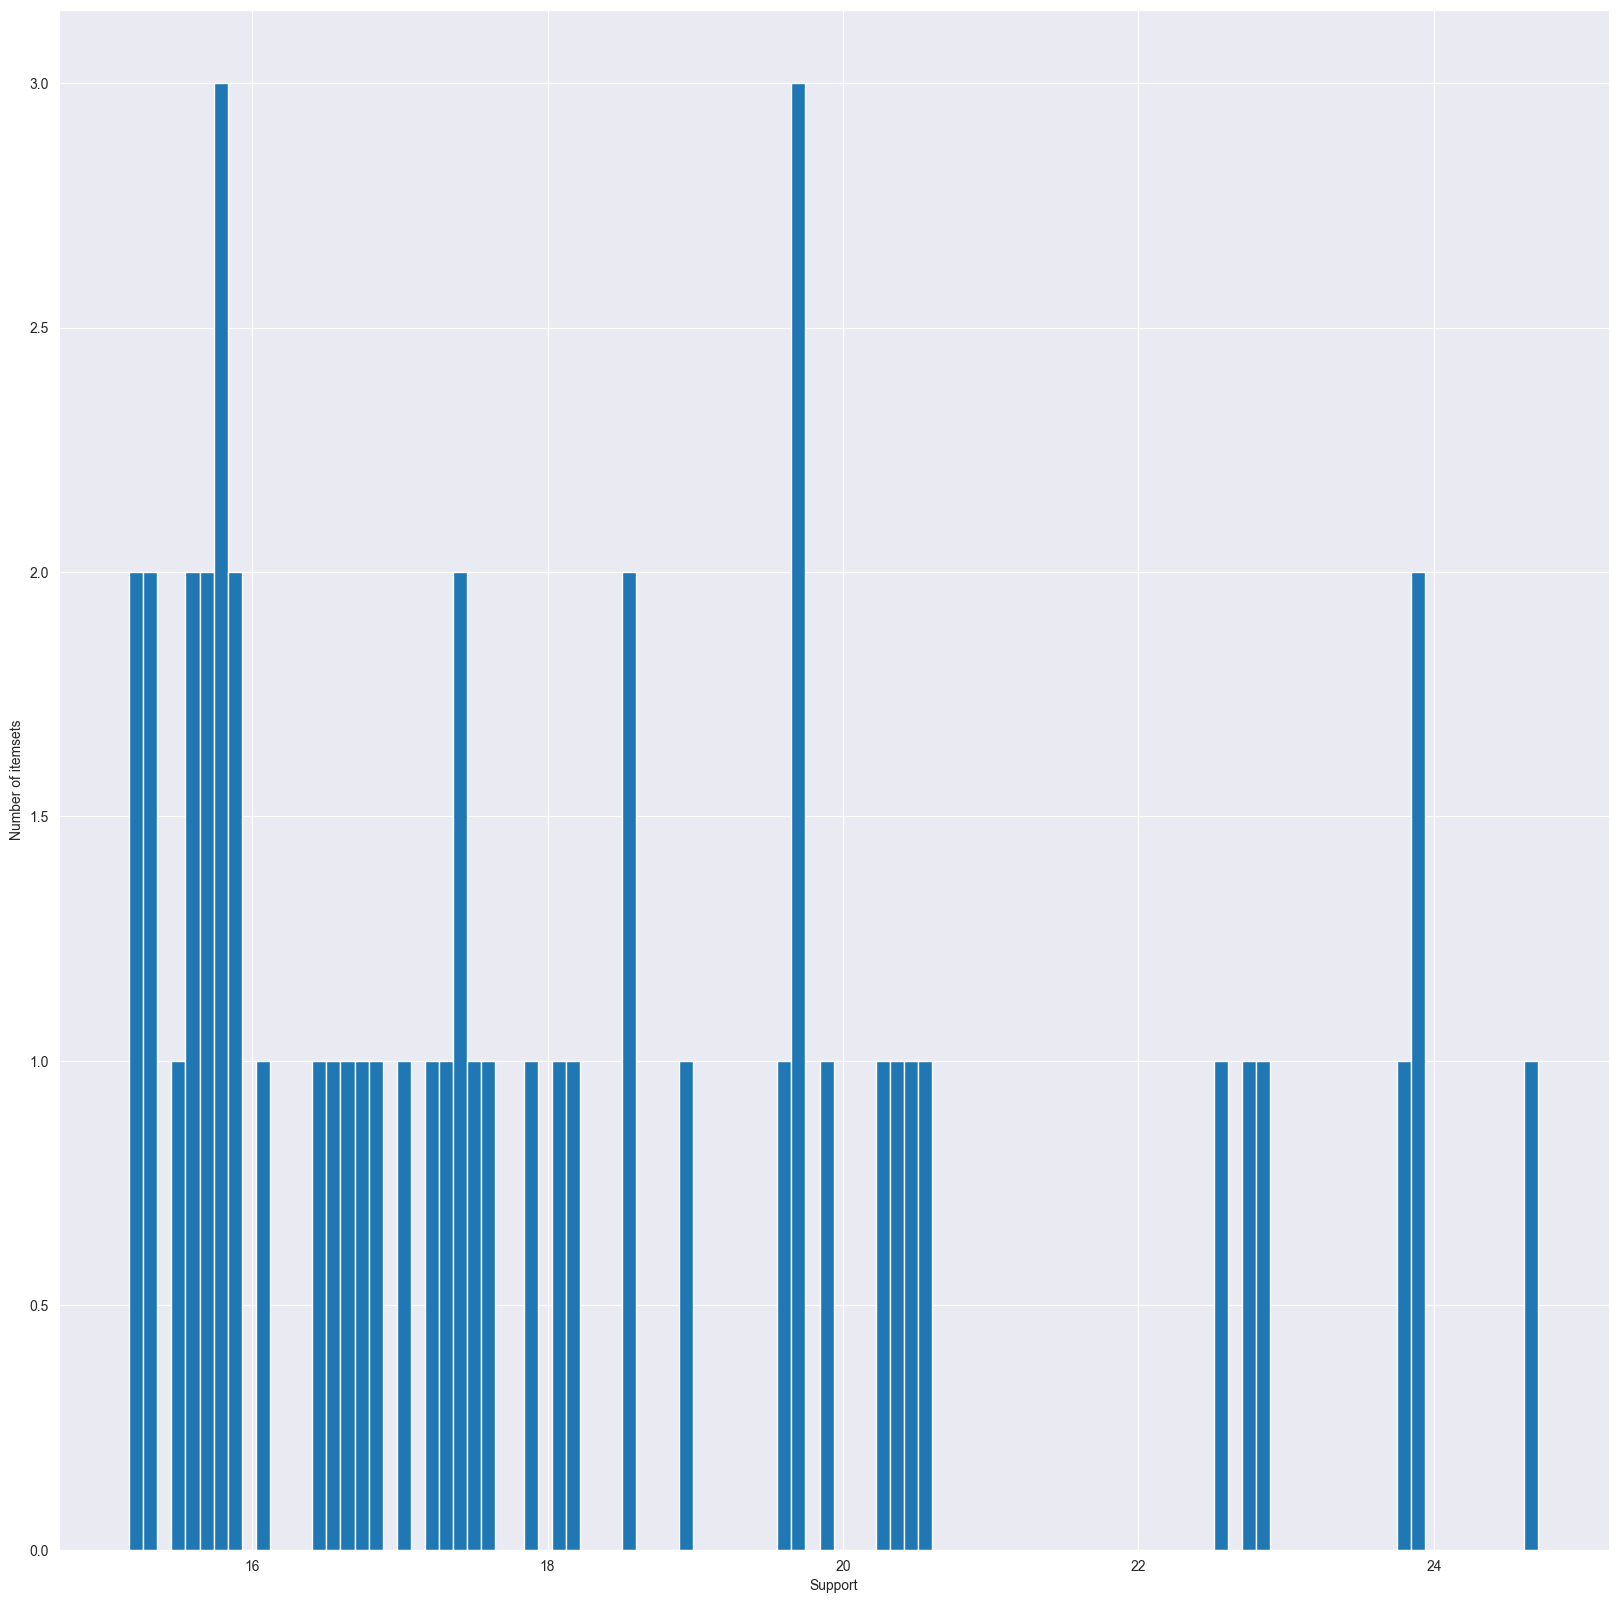

In [135]:
#plot the histogram of the support


Now the same but insead of the apriori function we use the fpgrowth function

In [136]:
supp = 15
zmin = 3

itemsets = fpgrowth(transactions, target="s", supp=supp, zmin=zmin, report='S')
pd.DataFrame(itemsets, columns=['frequent_itemsets', 'support'])

,frequent_itemsets,support
0,"((-0.001, 0.0412]_speechiness, major, not_expl...",24.706667
1,"((0.562, 0.834]_energy, major, not_explicit)",19.846667
2,"((-0.001, 0.562]_energy, major, not_explicit)",23.940000
3,"((-0.001, 0.562]_energy, (-0.001, 0.0412]_spee...",16.606667
4,"((0.0316, 0.415]_acousticness, major, not_expl...",20.273333
5,"((-0.001, 1.27e-05]_instrumentalness, major, n...",22.793333
6,"((-9.214, -5.791]_loudness, major, not_explicit)",20.453333
7,"((-0.001, 0.0316]_acousticness, major, not_exp...",18.586667
8,"((-5.791, 3.156]_loudness, major, not_explicit)",19.713333
9,"((0.377, 1.0]_instrumentalness, major, not_exp...",19.633333


## Closed Itemsets 

An item set is closed if non of its immediate supersets has the same support as the item set.

In [141]:
supp = 15
zmin = 3

itemsets = apriori(transactions, target="c", supp=supp, zmin=zmin, report='S')
closed_itemsets_df=pd.DataFrame(itemsets, columns=['closed_itemsets', 'support'])

closed_itemsets_df

,closed_itemsets,support
0,"((0.131, 0.28]_liveness, major, not_explicit)",15.346667
1,"((625.0, 7348.0]_n_beats, (288903.0, 4120258.0...",18.066667
2,"((625.0, 7348.0]_n_beats, major, not_explicit)",15.246667
3,"((0.664, 0.995]_valence, major, not_explicit)",15.326667
4,"((0.58, 0.695]_danceability, major, not_explicit)",15.686667
5,"((327.0, 461.0]_n_beats, major, not_explicit)",15.833333
6,"((0.28, 0.994]_liveness, major, not_explicit)",15.693333
7,"((180000.0, 227826.0]_duration, major, not_exp...",15.586667
8,"((227826.0, 288903.0]_duration, major, not_exp...",16.460000
9,"((288903.0, 4120258.0]_duration, major, not_ex...",15.166667


In [142]:
#Check is the closed itemsets are also frequent
closed_itemsets_df['is_frequent'] = closed_itemsets_df['support'].apply(lambda x: x >= supp)

# Print the closed itemsets that are also frequent
print(closed_itemsets_df[closed_itemsets_df['is_frequent']])

                                      closed_itemsets    support  is_frequent
0       ((0.131, 0.28]_liveness, major, not_explicit)  15.346667         True
1   ((625.0, 7348.0]_n_beats, (288903.0, 4120258.0...  18.066667         True
2      ((625.0, 7348.0]_n_beats, major, not_explicit)  15.246667         True
3       ((0.664, 0.995]_valence, major, not_explicit)  15.326667         True
4   ((0.58, 0.695]_danceability, major, not_explicit)  15.686667         True
5       ((327.0, 461.0]_n_beats, major, not_explicit)  15.833333         True
6       ((0.28, 0.994]_liveness, major, not_explicit)  15.693333         True
7   ((180000.0, 227826.0]_duration, major, not_exp...  15.586667         True
8   ((227826.0, 288903.0]_duration, major, not_exp...  16.460000         True
9   ((288903.0, 4120258.0]_duration, major, not_ex...  15.166667         True
10      ((461.0, 625.0]_n_beats, major, not_explicit)  15.800000         True
11      ((0.416, 0.664]_valence, major, not_explicit)  15.813333

In [144]:
sup = 2
supp = 15
zmin = 3

itemsets = fpgrowth(transactions, target="c", supp=supp, zmin=zmin, report='S')
fpgrowth_closed_ds = pd.DataFrame(itemsets, columns=['closed_itemsets', 'support'])

In [147]:
#Check is the closed itemsets are also frequent
fpgrowth_closed_ds['is_frequent'] = fpgrowth_closed_ds['support'].apply(lambda x: x >= supp)

# Print the number of itemsets that are also frequent
print(fpgrowth_closed_ds[fpgrowth_closed_ds['is_frequent']])

                                      closed_itemsets    support  is_frequent
0       ((0.131, 0.28]_liveness, major, not_explicit)  15.346667         True
1   ((625.0, 7348.0]_n_beats, (288903.0, 4120258.0...  18.066667         True
2      ((625.0, 7348.0]_n_beats, major, not_explicit)  15.246667         True
3       ((0.664, 0.995]_valence, major, not_explicit)  15.326667         True
4   ((0.58, 0.695]_danceability, major, not_explicit)  15.686667         True
5       ((327.0, 461.0]_n_beats, major, not_explicit)  15.833333         True
6       ((0.28, 0.994]_liveness, major, not_explicit)  15.693333         True
7   ((180000.0, 227826.0]_duration, major, not_exp...  15.586667         True
8   ((227826.0, 288903.0]_duration, major, not_exp...  16.460000         True
9       ((0.416, 0.664]_valence, major, not_explicit)  15.813333         True
10  ((288903.0, 4120258.0]_duration, major, not_ex...  15.166667         True
11      ((461.0, 625.0]_n_beats, major, not_explicit)  15.800000

## Maximal Itemsets

In [151]:
supp = 20
zmin = 3

itemsets = apriori(transactions, target="m", supp=supp, zmin=zmin, report='S')
pd.DataFrame(itemsets, columns=['maximal_itemsets', 'support'])

,maximal_itemsets,support
0,"((0.0412, 0.0698]_speechiness, major, not_expl...",20.600000
1,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",22.813333
2,"((0.415, 0.996]_acousticness, major, not_expli...",23.886667
3,"((1.27e-05, 0.377]_instrumentalness, major, no...",20.320000
4,"((-49.532, -9.214]_loudness, (-0.001, 0.562]_e...",23.760000
5,"((-49.532, -9.214]_loudness, major, not_explicit)",22.580000
6,"((-9.214, -5.791]_loudness, major, not_explicit)",20.453333
7,"((-0.001, 1.27e-05]_instrumentalness, major, n...",22.793333
8,"((0.0316, 0.415]_acousticness, major, not_expl...",20.273333
9,"((-0.001, 0.562]_energy, major, not_explicit)",23.940000


In [152]:
sup = 2
supp = 20
zmin = 3

itemsets = fpgrowth(transactions, target="m", supp=supp, zmin=zmin, report='S')
pd.DataFrame(itemsets, columns=['maximal_itemsets', 'support'])

,maximal_itemsets,support
0,"((0.0412, 0.0698]_speechiness, major, not_expl...",20.600000
1,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",22.813333
2,"((0.415, 0.996]_acousticness, major, not_expli...",23.886667
3,"((1.27e-05, 0.377]_instrumentalness, major, no...",20.320000
4,"((-49.532, -9.214]_loudness, (-0.001, 0.562]_e...",23.760000
5,"((-49.532, -9.214]_loudness, major, not_explicit)",22.580000
6,"((-9.214, -5.791]_loudness, major, not_explicit)",20.453333
7,"((-0.001, 1.27e-05]_instrumentalness, major, n...",22.793333
8,"((0.0316, 0.415]_acousticness, major, not_expl...",20.273333
9,"((-0.001, 0.562]_energy, major, not_explicit)",23.940000


# Support plots

Support vs number of itemsets

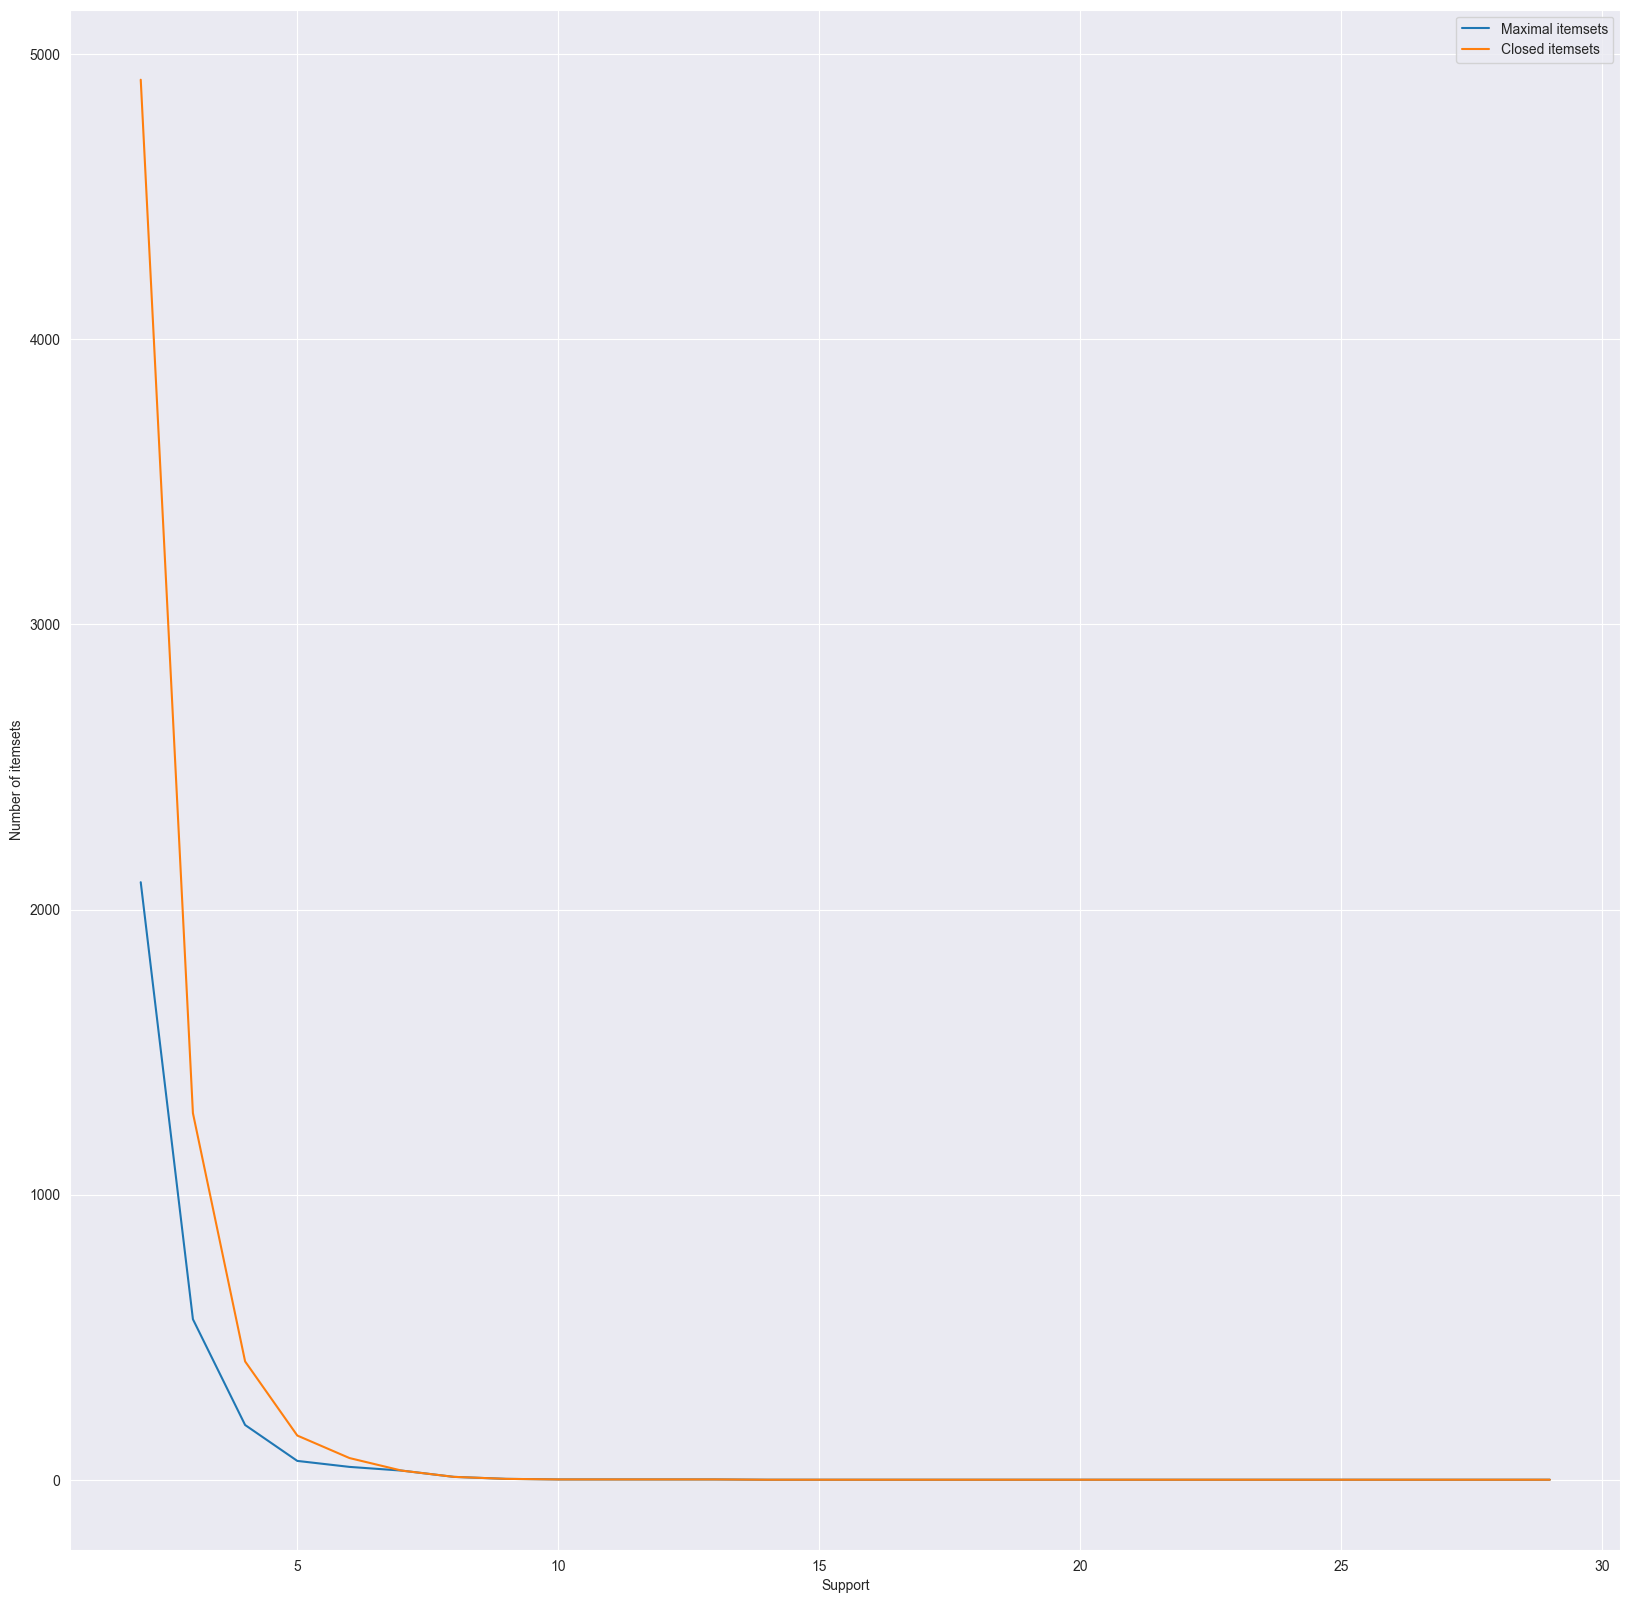

In [129]:
len_max_it = []
len_cl_it = []
max_supp = 30
zmin = 5

for i in range (2, max_supp):
    max_itemsets = apriori(transactions, target="m", supp=i, zmin=zmin)
    cl_itemsets = apriori(transactions, target="c", supp=i, zmin=zmin)
    len_max_it.append(len(max_itemsets))
    len_cl_it.append(len(cl_itemsets))
    
plt.figure(figsize=(20, 20))
plt.plot(np.arange(2, max_supp), len_max_it, label='Maximal itemsets')
plt.plot(np.arange(2, max_supp), len_cl_it, label='Closed itemsets')
plt.xlabel('Support')
plt.ylabel('Number of itemsets')
plt.legend()
plt.show()

Closed vs maximal vs frequent

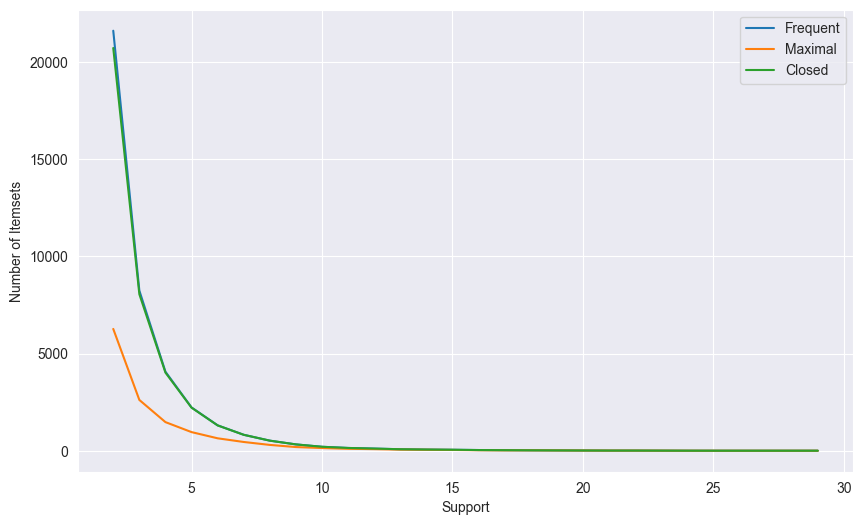

In [154]:
import matplotlib.pyplot as plt

# Define a range of support values
support_values = range(2, 30)

# Initialize lists to store the counts
frequent_counts = []
maximal_counts = []
closed_counts = []

# For each support value
for supp in support_values:
    # Generate frequent, maximal, and closed itemsets
    frequent_itemsets = apriori(transactions, target="s", supp=supp, zmin=3)
    maximal_itemsets = apriori(transactions, target="m", supp=supp, zmin=3)
    closed_itemsets = apriori(transactions, target="c", supp=supp, zmin=3)
    
    # Count the number of itemsets and store the counts
    frequent_counts.append(len(frequent_itemsets))
    maximal_counts.append(len(maximal_itemsets))
    closed_counts.append(len(closed_itemsets))

# Plot the counts against the support values
plt.figure(figsize=(10, 6))
plt.plot(support_values, frequent_counts, label='Frequent')
plt.plot(support_values, maximal_counts, label='Maximal')
plt.plot(support_values, closed_counts, label='Closed')
plt.xlabel('Support')
plt.ylabel('Number of Itemsets')
plt.legend()
plt.show()

Support vs number of itemsets for minor/not minor songs

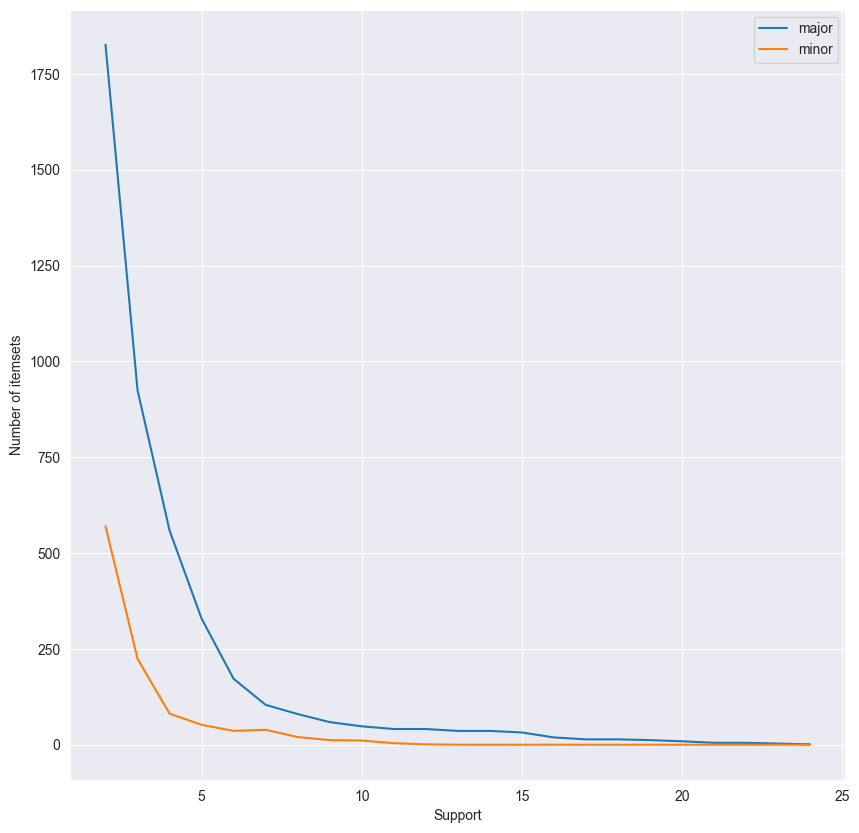

In [156]:
filter_1 = []
filter_2 = []
max_supp = 25

for i in range (2, max_supp):
    max_itemsets = apriori(transactions, target="m", supp=i, zmin=zmin)
    filter_1.append(len([item for item in max_itemsets if 'major' in item[0]]))
    filter_2.append(len([item for item in max_itemsets if 'minor' in item[0]]))
    
plt.figure(figsize=(10, 10))
plt.plot(np.arange(2, max_supp), filter_1, label='major')
plt.plot(np.arange(2, max_supp), filter_2, label='minor')
plt.xlabel('Support')
plt.ylabel('Number of itemsets')
plt.legend()
plt.xticks()
plt.show()

Creation of rules dataset

In [265]:
supp = 15  
zmin = 3

rules = apriori(transactions, target="r", supp=supp, zmin=zmin, report='aScl')
rules_df = pd.DataFrame(
    rules,
    columns=['consequent', 'antecedent', 'abs_support', '%_support', 'confidence', 'lift'],)

rules_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
29,"(-0.001, 0.562]_energy","((0.415, 0.996]_acousticness, (-49.532, -9.214...",2647,17.646667,0.895770,2.682481
30,"(-0.001, 0.562]_energy","((0.415, 0.996]_acousticness, (-49.532, -9.214...",2676,17.840000,0.894684,2.679230
24,"(0.834, 1.0]_energy","((-0.001, 0.0316]_acousticness, (-5.791, 3.156...",1985,13.233333,0.820248,2.472116
34,major,"((0.415, 0.996]_acousticness, (-0.001, 0.0412]...",1917,12.780000,0.803100,1.208396
56,major,"((-0.001, 0.562]_energy, (-0.001, 0.0412]_spee...",2000,13.333333,0.802890,1.208081
...,...,...,...,...,...,...
49,not_explicit,"((-5.791, 3.156]_loudness, (-0.001, 1.27e-05]_...",2027,13.513333,0.883224,0.944019
52,not_explicit,"((-0.001, 1.27e-05]_instrumentalness, (0.0316,...",2058,13.720000,0.876117,0.936423
40,not_explicit,"((0.0698, 0.939]_speechiness, major)",2616,17.440000,0.859396,0.918550
23,not_explicit,"((0.834, 1.0]_energy, (0.0698, 0.939]_speechin...",2044,13.626667,0.857023,0.916014


In [182]:
# Quantitative Analysis
# Descriptive statistics
print("Descriptive Statistics:")
print(rules_df.describe())

# Correlation

# Qualitative Analysis
# Rules with highest lift
print("\nRules with Highest Lift:")
print(rules_df.sort_values(by='lift', ascending=False).head())

# Rules with highest confidence
print("\nRules with Highest Confidence:")
print(rules_df.sort_values(by='confidence', ascending=False).head())

Descriptive Statistics:
       abs_support  %_support  confidence       lift
count    62.000000  62.000000   62.000000  62.000000
mean   2584.096774  17.227312    0.929457   1.097338
std     464.845284   3.098969    0.053060   0.350659
min    1865.000000  12.433333    0.801274   0.876593
25%    2290.000000  15.266667    0.903144   0.992551
50%    2489.000000  16.593333    0.938078   1.013076
75%    2919.750000  19.465000    0.969618   1.053253
max    3706.000000  24.706667    0.994275   2.682481

Rules with Highest Lift:
                consequent                                         antecedent  \
29  (-0.001, 0.562]_energy  ((0.415, 0.996]_acousticness, (-49.532, -9.214...   
30  (-0.001, 0.562]_energy  ((0.415, 0.996]_acousticness, (-49.532, -9.214...   
24     (0.834, 1.0]_energy  ((-0.001, 0.0316]_acousticness, (-5.791, 3.156...   
34                   major  ((0.415, 0.996]_acousticness, (-0.001, 0.0412]...   
56                   major  ((-0.001, 0.562]_energy, (-0.001, 0.0412

In [184]:
#create dataset with rules with higest confidence 
rules_df.sort_values(by='confidence', ascending=False).head(10)


,consequent,antecedent,abs_support,%_support,confidence,lift
45,not_explicit,"((-49.532, -9.214]_loudness, (0.377, 1.0]_inst...",2779,18.526667,0.994275,1.062714
36,not_explicit,"((0.415, 0.996]_acousticness, (-0.001, 0.0412]...",2387,15.913333,0.993342,1.061716
58,not_explicit,"((-0.001, 0.562]_energy, (-0.001, 0.0412]_spee...",2491,16.606667,0.992035,1.060320
32,not_explicit,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",2602,17.346667,0.990483,1.058661
61,not_explicit,"((-0.001, 0.0412]_speechiness, major)",3706,24.706667,0.990115,1.058267
46,not_explicit,"((-49.532, -9.214]_loudness, (-0.001, 0.562]_e...",2587,17.246667,0.989671,1.057793
28,not_explicit,"((0.415, 0.996]_acousticness, (-49.532, -9.214...",2647,17.646667,0.989163,1.057250
31,not_explicit,"((0.415, 0.996]_acousticness, (-49.532, -9.214...",2955,19.700000,0.987964,1.055968
48,not_explicit,"((-49.532, -9.214]_loudness, major)",3387,22.580000,0.986026,1.053897
33,not_explicit,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",3422,22.813333,0.983616,1.051321


In [320]:
supp = 15
zmin = 3

rules_fp = fpgrowth(transactions, target="r", supp=supp, zmin=zmin, report='aScl')

rules_fp_df = pd.DataFrame(
    rules,
    columns=['consequent', 'antecedent', 'abs_support', '%_support', 'confidence', 'lift'],)

rules_fp_df.sort_values(by="lift", axis=0, ascending=False)

,consequent,antecedent,abs_support,%_support,confidence,lift
29,"(-0.001, 0.562]_energy","((0.415, 0.996]_acousticness, (-49.532, -9.214...",2647,17.646667,0.895770,2.682481
30,"(-0.001, 0.562]_energy","((0.415, 0.996]_acousticness, (-49.532, -9.214...",2676,17.840000,0.894684,2.679230
24,"(0.834, 1.0]_energy","((-0.001, 0.0316]_acousticness, (-5.791, 3.156...",1985,13.233333,0.820248,2.472116
34,major,"((0.415, 0.996]_acousticness, (-0.001, 0.0412]...",1917,12.780000,0.803100,1.208396
56,major,"((-0.001, 0.562]_energy, (-0.001, 0.0412]_spee...",2000,13.333333,0.802890,1.208081
...,...,...,...,...,...,...
49,not_explicit,"((-5.791, 3.156]_loudness, (-0.001, 1.27e-05]_...",2027,13.513333,0.883224,0.944019
52,not_explicit,"((-0.001, 1.27e-05]_instrumentalness, (0.0316,...",2058,13.720000,0.876117,0.936423
40,not_explicit,"((0.0698, 0.939]_speechiness, major)",2616,17.440000,0.859396,0.918550
23,not_explicit,"((0.834, 1.0]_energy, (0.0698, 0.939]_speechin...",2044,13.626667,0.857023,0.916014


# Classification

In [163]:
rules_df[rules_df["consequent"] == "major"]

,consequent,antecedent,abs_support,%_support,confidence,lift
0,major,"(C, not_explicit)",1397,9.313333,0.838535,1.261714
2,major,"(G, not_explicit)",1433,9.553333,0.850950,1.280394
201,major,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",1475,9.833333,0.814467,1.225500
202,major,"((0.415, 0.996]_acousticness, (-0.001, 0.562]_...",1484,9.893333,0.814043,1.224861
207,major,"((0.415, 0.996]_acousticness, (-0.001, 0.0412]...",1917,12.780000,0.803100,1.208396
208,major,"((0.415, 0.996]_acousticness, (-0.001, 0.0412]...",1927,12.846667,0.801914,1.206612
268,major,"((-0.001, 1.27e-05]_instrumentalness, (-0.001,...",1244,8.293333,0.821122,1.235513
272,major,"((-0.001, 1.27e-05]_instrumentalness, (-0.001,...",1596,10.640000,0.831683,1.251404
273,major,"((-0.001, 1.27e-05]_instrumentalness, (-0.001,...",1609,10.726667,0.828954,1.247298
281,major,"((-0.001, 0.562]_energy, (-0.001, 0.0412]_spee...",2000,13.333333,0.802890,1.208081


In [164]:
print("to predict: ", [r for r in rules if r[0] == "major"][0][0])
print("how?: ", [r for r in rules if r[0] == "major"][0][1])

to predict:  major
how?:  ('C', 'not_explicit')


In [187]:
len_r = []
min_sup = 1
max_sup = 30
min_conf = 50
max_conf = 90
for i in range(min_sup, max_sup):
    len_r_wrt_i = []
    for j in range(min_conf, max_conf):
        rules = apriori(transactions, target="r", supp=i, conf=j, report='aScl')
        len_r_wrt_i.append(len(rules))
        
    len_r.append(len_r_wrt_i)

len_r = np.array(len_r)

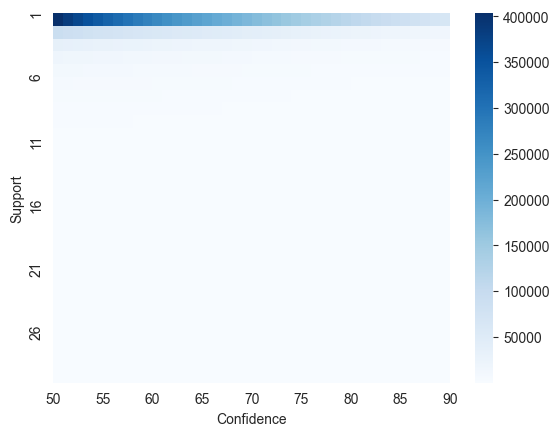

In [188]:
sns.heatmap(len_r, cmap='Blues', fmt='g')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.yticks(np.arange(0, max_sup-min_sup + 1, 5), np.arange(min_sup, max_sup+1,5))
plt.xticks(np.arange(0, max_conf-min_conf + 1, 5), np.arange(min_conf, max_conf+1,5))
plt.show()

In [266]:
# Filter the DataFrame to only include rows where the consequent is 'major'
major_rules_df = rules_df[rules_df['consequent'] == 'major']
#minor_rules_df = rules_df[rules_df['consequent'] == 'minor']

# Find the rule with the highest lift
most_interesting_major_rule = major_rules_df.loc[major_rules_df['lift'].idxmax()]
#most_intresting_minor_rule = minor_rules_df.loc[minor_rules_df['lift'].idxmax()]

most_interesting_major_rule#%%
#most_intresting_minor_rule

consequent                                                 major
antecedent     ((0.415, 0.996]_acousticness, (-0.001, 0.0412]...
abs_support                                                 1917
%_support                                                  12.78
confidence                                                0.8031
lift                                                    1.208396
Name: 34, dtype: object

In [267]:
antecedent = most_interesting_major_rule['antecedent']
consequent = most_interesting_major_rule['consequent']

#antecedent_minor = most_intresting_minor_rule['antecedent']
#consequent_minor = most_intresting_minor_rule['consequent']

In [313]:
predictions = []
# Initialize an empty list to store the indices of the rows that meet the conditions
indices = []

# Iterate over the test dataset
for index, row in df_test.iterrows():
    # Check if the conditions are met
    if (0.415 <= row['acousticness'] <= 0.996) and (-0.001 <= row['speechiness'] <= 0.0412) and (row['explicit'] == 0):
        # If the conditions are met, append the index to the list
        indices.append(index)
        print(index)
        predictions.append('1')
    else: 
        predictions.append('0')

# Print the indices of the rows that meet the conditions

6
7
8
10
21
22
30
31
52
53
64
70
78
87
96
102
104
109
111
112
131
134
135
156
159
164
165
167
171
172
182
186
191
194
205
212
214
218
221
224
240
248
259
265
267
271
273
284
288
290
291
298
300
301
304
317
325
326
328
347
358
377
381
385
393
395
396
405
410
413
420
424
431
437
438
440
441
445
448
449
476
478
481
485
489
490
492
505
509
516
517
525
529
531
532
534
545
547
548
556
559
563
566
567
569
572
580
589
594
600
601
602
608
612
613
619
624
629
655
663
666
667
670
674
678
684
685
692
697
703
704
725
733
735
747
767
770
778
779
783
813
815
818
828
832
835
844
848
857
859
876
878
883
887
907
910
925
935
936
937
944
965
968
971
973
981
982
987
1001
1013
1017
1020
1030
1035
1037
1042
1043
1054
1057
1060
1065
1089
1097
1102
1113
1141
1144
1150
1152
1154
1156
1168
1195
1196
1201
1203
1208
1216
1220
1226
1228
1230
1234
1242
1244
1247
1253
1257
1269
1304
1309
1311
1314
1317
1324
1327
1328
1336
1340
1345
1350
1354
1357
1358
1363
1366
1375
1379
1384
1385
1389
1390
1393
1406
1418
1423
1430
1

In [317]:
len(indices)

825

In [318]:
#count the number of times mode is 1 and predictions is 1
x = df_test[(df_test['mode'] == 1) & (df_test['predictions'] == 1)].count()
print(x)

name                    678
duration_ms             678
explicit                678
popularity              678
artists                 678
album_name              678
danceability            678
energy                  678
key                     678
loudness                678
mode                    678
speechiness             678
acousticness            678
instrumentalness        678
liveness                678
valence                 678
tempo                   678
features_duration_ms    678
time_signature          678
n_beats                 678
n_bars                  678
processing              678
genre                   678
predictions             678
dtype: int64


In [314]:
# for each indices in the list create a new column in the test dataset and set the value to 1
df_test['predictions'] = 0
df_test.loc[indices, 'predictions'] = 1


In [296]:
#drop NaN from 'mode' column
df_test.dropna(subset=['mode'], inplace=True)

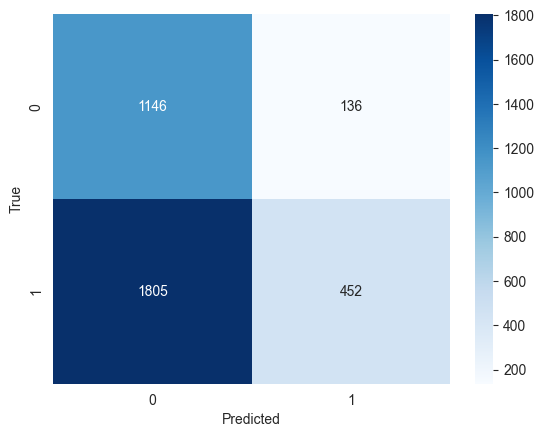

In [299]:
#count the number of times mode is 1 and predictions is 1 and print it
df_test[(df_test['mode'] == 1) & (df_test['predictions'] == 1)].count()

#count the number of times mode is 1 and predictions is 0
df_test[(df_test['mode'] == 1) & (df_test['predictions'] == 0)].count()

#count the number of times mode is 0 and predictions is 1
df_test[(df_test['mode'] == 0) & (df_test['predictions'] == 1)].count()

#count the number of times mode is 0 and predictions is 0
df_test[(df_test['mode'] == 0) & (df_test['predictions'] == 0)].count()


# Calculate the counts
TN = df_test[(df_test['mode'] == 0) & (df_test['predictions'] == 0)].count()[0]
FP = df_test[(df_test['mode'] == 0) & (df_test['predictions'] == 1)].count()[0]
FN = df_test[(df_test['mode'] == 1) & (df_test['predictions'] == 0)].count()[0]
TP = df_test[(df_test['mode'] == 1) & (df_test['predictions'] == 1)].count()[0]

# Create the confusion matrix
conf_matrix = np.array([[TN, FP], [FN, TP]])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [291]:
true_labels = df_test['mode']  # Replace 'target_variable' with the name of your actual target variable column
#transform true label to string
#create dataset with only explicit, acousticness and speechiness and mode
df_test_explicit_acousticness_speechiness = df_test[['explicit', 'acousticness', 'speechiness', 'mode']]


# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro', zero_division=1)
recall = recall_score(true_labels, predictions, average='macro', zero_division=1)
conf_matrix = confusion_matrix(true_labels, predictions)

# Print the evaluation results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

#plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/Users/lorenzocascone/anaconda3/envs/DM1/lib/python3.11/site-packages/sklearn/utils/multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


ValueError: Input y_true contains NaN.

In [274]:
#create dataset with true labels and predictions
df_test['predictions'] = predictions
df_test['true_labels'] = true_labels

In [315]:
df_test

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre,predictions
0,Untrue,206826,0,32,Coal Chamber,Chamber Music,0.383,0.9510,0,-3.743,...,0.2610,0.668,110.584,206827,4.0,385.0,96.0,3.349057,5,0
1,High Roller,329733,0,41,The Crystal Method,Vegas,0.464,0.5790,5,-9.136,...,0.0992,0.140,171.752,329733,4.0,935.0,235.0,1.279305,19,0
2,Na Tum Jano Na Hum (ReVibe),136000,0,40,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.611,0.7780,9,-4.803,...,0.1390,0.285,90.024,136000,4.0,200.0,49.0,1.343558,14,0
3,いじわるなハロー,247040,0,25,Perfume,Cling Cling,0.500,0.9580,0,-1.695,...,0.7320,0.955,130.059,247040,4.0,526.0,132.0,3.349057,6,0
4,Hit The Ceiling,208120,0,0,Audio Bullys,Ego War,0.802,0.6840,1,-8.839,...,0.2360,0.637,130.022,208120,4.0,440.0,110.0,2.367412,19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Ich war es,80813,0,17,Germaine Franco,Encanto (Deutscher Original Film-Soundtrack),0.217,0.0754,11,-16.629,...,0.1350,0.201,142.026,80813,5.0,175.0,44.0,0.748116,12,1
4996,Giahe Vahshi,261500,0,2,Saeed Dehghan;Pari Eskandari;Beatbynajwa,Oryan,0.467,0.7820,10,-8.136,...,0.0971,0.203,145.059,261500,4.0,621.0,158.0,0.757389,1,0
4997,Taste - Reaper Remix,258000,0,19,Shiv-R,"Infacted Compilation, Vol. 5",0.524,0.9730,0,-5.214,...,0.1070,0.840,140.029,258000,4.0,594.0,149.0,3.349057,5,0
4998,Romove,404506,0,19,Skyforger,Senprusija,0.166,0.9750,2,-3.585,...,0.0656,0.233,75.005,404507,4.0,550.0,138.0,3.700483,2,0
